In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 5 - Some examples of data analysis
## 5.1 Pearson correlation


The Pearson product-moment correlation coefficient, usually denoted r, is a widely used measure of the relationship between two variables. It ranges from −1, indicating a perfect negative linear relationship, to +1, indicating a perfect positive relationship. A value of 0 indicates that there is no linear relationship. Usually the correlation r is reported as a single point estimate, perhaps together with a frequentist significance test.

But, rather than just having a single number to measure the correlation, it would be nice to have a posterior distribution for r, saying how likely each possible level of correlation was. There are frequentist confidence interval methods that try to do this, as well as various analytic Bayesian results based on asymptotic approximations (e.g., Donner & Wells, 1986).


Inferring the mean and variance of a Gaussian distribution. 
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ x_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$

The observed data take the form _x<sub>i</sub>_ = (_x<sub>i1</sub>_, _x<sub>i2</sub>_) for the ith observation, and, following the theory behind the correlation coefficient, are modeled as draws from a multivariate Gaussian distribution. The parameters of this distribution are the means _μ_ = (_μ<sub>1</sub>_,_μ<sub>2</sub>_) and standard deviations _σ_ = (_σ<sub>1</sub>_,_σ<sub>2</sub>_) of the two variables, and the correlation coefficient _r_ that links them.

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 90.192:  19%|█▉        | 38398/200000 [00:29<02:09, 1251.25it/s] 
Convergence archived at 38400
Interrupted at 38,400 [19%]: Average Loss = 6,382.9
100%|██████████| 3500/3500.0 [01:00<00:00, 58.14it/s]


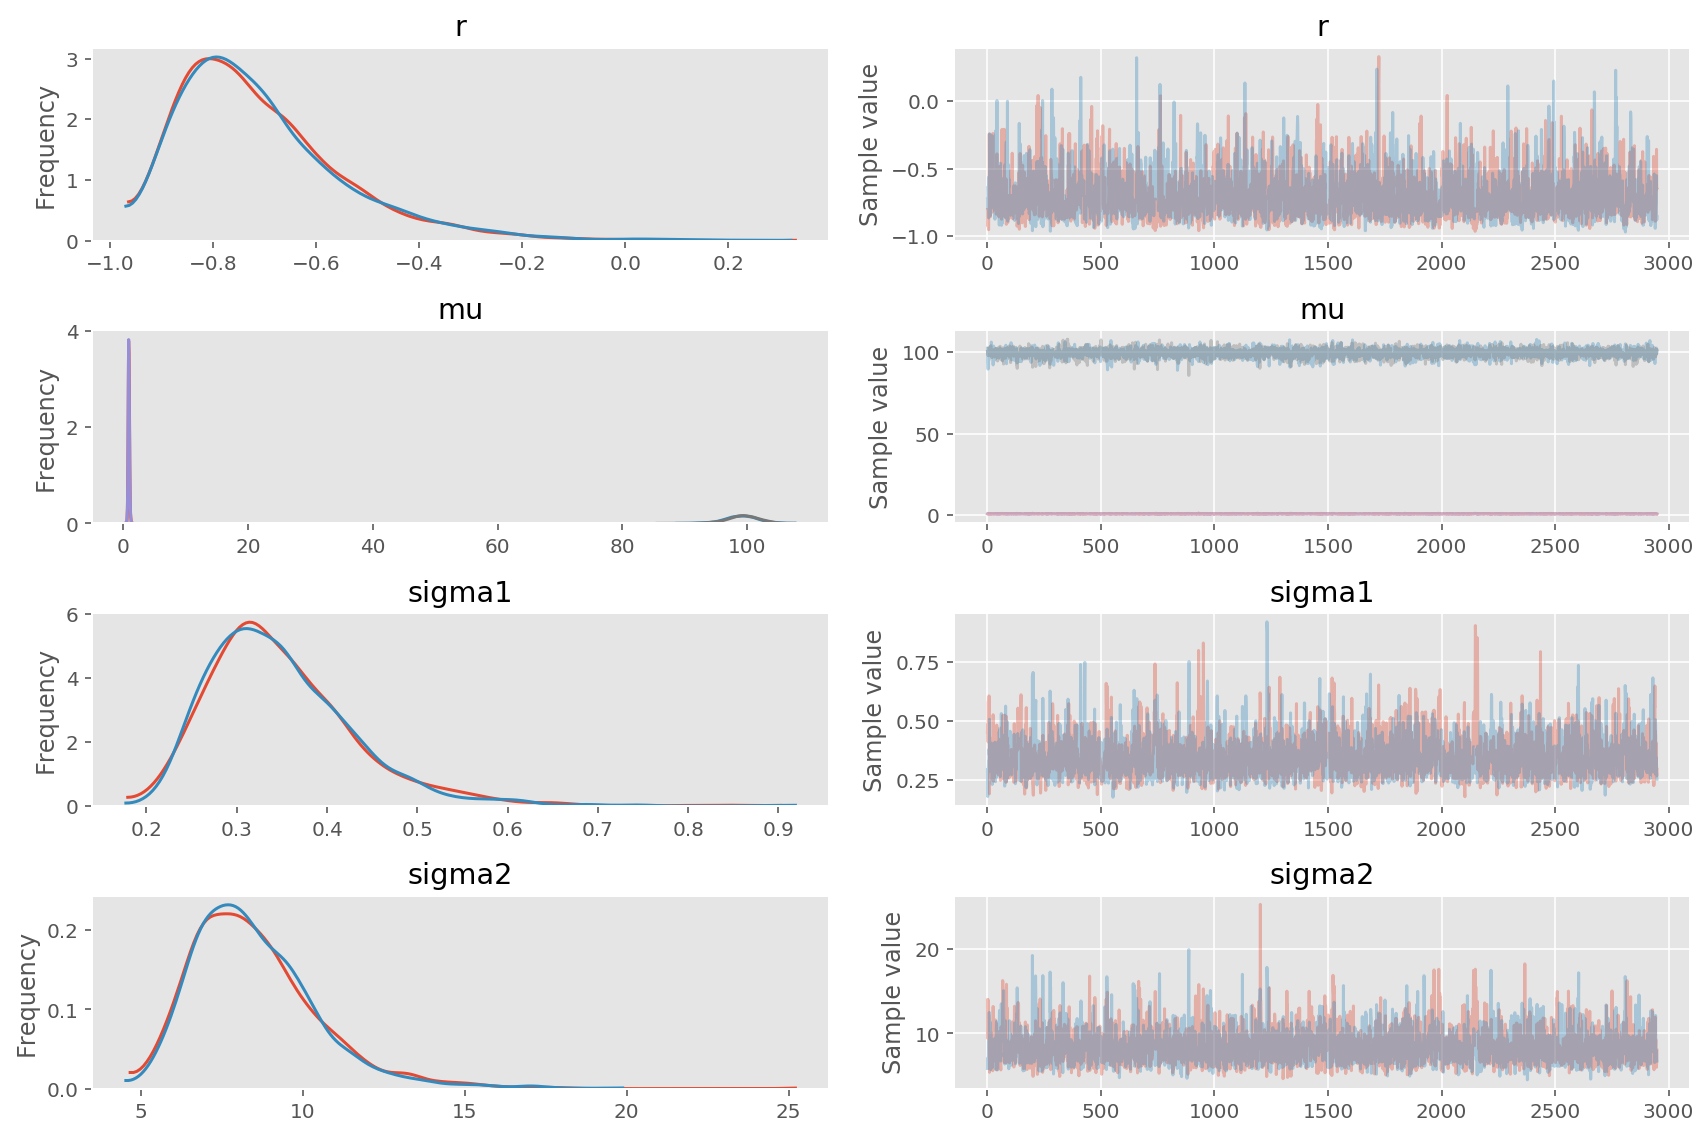

In [2]:
# The datasets:
y = np.array([.8, 102, 1,98, .5,100, 0.9,105, .7,103, 
               0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93]).reshape((11, 2))

# y = np.array([.8,102, 1,98, .5,100, 0.9,105, .7,103, 
#                0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93,
#                .8,102, 1,98, .5,100, 0.9,105, .7,103, 
#                0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93]).reshape((22, 2))

with pm.Model() as model:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r', lower=-1, upper=1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma('lambda1', alpha=.001, beta=.001)
    lambda2 = pm.Gamma('lambda2', alpha=.001, beta=.001)
    sigma1 = pm.Deterministic('sigma1', 1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic('sigma2', 1/np.sqrt(lambda2))
    
    cov = pm.Deterministic('cov', tt.stacklists([[lambda1**-1, r*sigma1*sigma2],
                                                [r*sigma1*sigma2, lambda2**-1]]))

    # xi∼MvGaussian((μ1,μ2),[σ1^2,rσ1σ2;rσ1σ2,σ2^2]^−1)
    yd = pm.MvNormal('yd', mu=mu, cov=cov, observed=y,shape=2)

    trace2=pm.sample(3e3, njobs=2)

pm.traceplot(trace2[50:], varnames=['r', 'mu', 'sigma1', 'sigma2']);

The r estimation is:  -0.70336663496
The Pearson correlation r is:  -0.810967075636


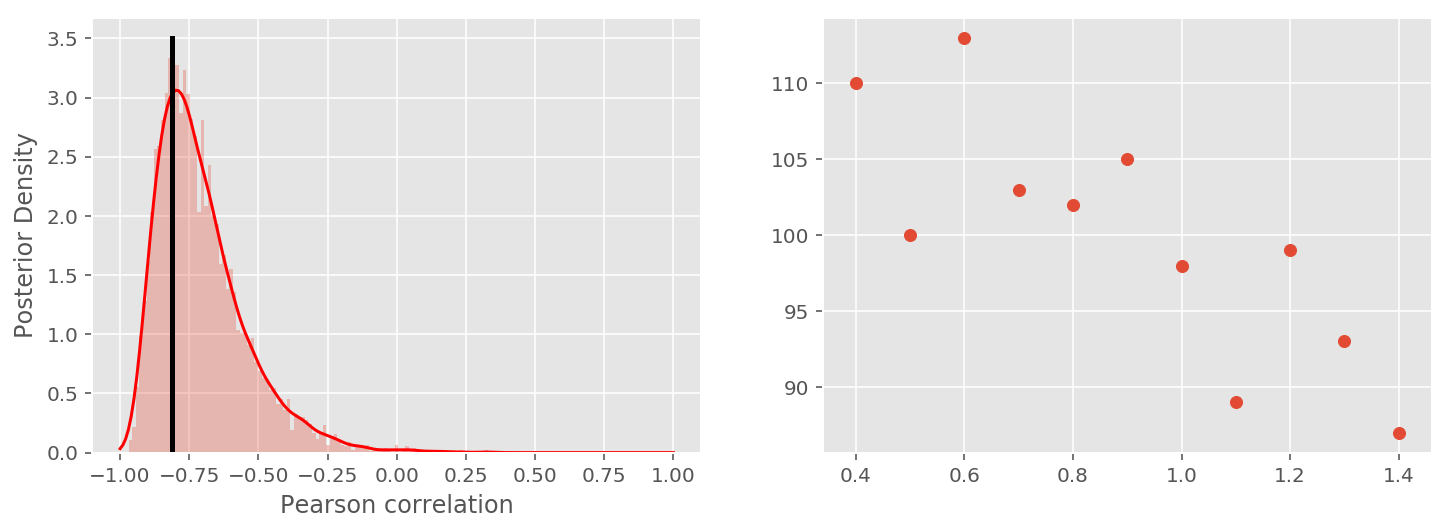

In [3]:
from matplotlib import gridspec
from scipy.stats.kde import gaussian_kde
import scipy as scipy 

r = trace2['r'][50:]
freqr = scipy.corrcoef(y[:, 0], y[:, 1])
print('The r estimation is: ', np.mean(r, axis=0))
print('The Pearson correlation r is: ', freqr[0, 1])

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
my_pdf = gaussian_kde(r)
x=np.linspace(-1, 1, 200)
ax0.plot(x, my_pdf(x), 'r') # distribution function
ax0.hist(r, bins=100, normed=1, alpha=.3)
ax0.plot([freqr[0, 1], freqr[0, 1]], [0, 3.5], 'k', lw=2.5)
plt.xlabel('Pearson correlation')
plt.ylabel('Posterior Density')

ax1 = plt.subplot(gs[1])
ax1.scatter(y[:, 0], y[:, 1])
plt.show()

## 5.2 Pearson correlation with uncertainty

  
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ y_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$
$$ x_{ij} \sim \text{Gaussian}(y_{ij},\lambda_{j}^e) $$  

In [4]:
# The datasets:
y = np.array([.8, 102, 1,98, .5,100, 0.9,105, .7,103, 
               0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93]).reshape((11, 2))
# y = np.array([.8,102, 1,98, .5,100, 0.9,105, .7,103, 
#                0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93,
#                .8,102, 1,98, .5,100, 0.9,105, .7,103, 
#                0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93]).reshape((22, 2))

n1, n2 = np.shape(y)
sigmaerror = np.array([.03, 1])
se = np.tile(sigmaerror, (n1, 1))

with pm.Model() as model2:
    # r∼Uniform(−1,1)
    r = pm.Uniform('r', lower=-1, upper=1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=n2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma('lambda1', alpha=.001, beta=.001)
    lambda2 = pm.Gamma('lambda2', alpha=.001, beta=.001)
    sigma1 = pm.Deterministic('sigma1', 1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic('sigma2', 1/np.sqrt(lambda2))
    
    cov = pm.Deterministic('cov', tt.stacklists([[lambda1**-1, r*sigma1*sigma2],
                                                [r*sigma1*sigma2, lambda2**-1]]))
    
    # xi∼MvGaussian((μ1,μ2),[σ1^2,rσ1σ2;rσ1σ2,σ2^2]^−1)
    yd = pm.MvNormal('yd', mu=mu, cov=cov, shape=(n1, n2))
    
    xi = pm.Normal('xi', mu=yd , sd=sigmaerror, observed=y)
    
    trace2=pm.sample(1e4, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 7,859.3: 100%|██████████| 200000/200000 [02:44<00:00, 1213.72it/s]
Finished [100%]: Average Loss = 7,858.5
100%|█████████▉| 10496/10500.0 [03:09<00:00, 53.53it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 10500/10500.0 [03:10<00:00, 55.26it/s]


The r estimation is:  -0.702799132021
The Pearson correlation r is:  -0.810967075636


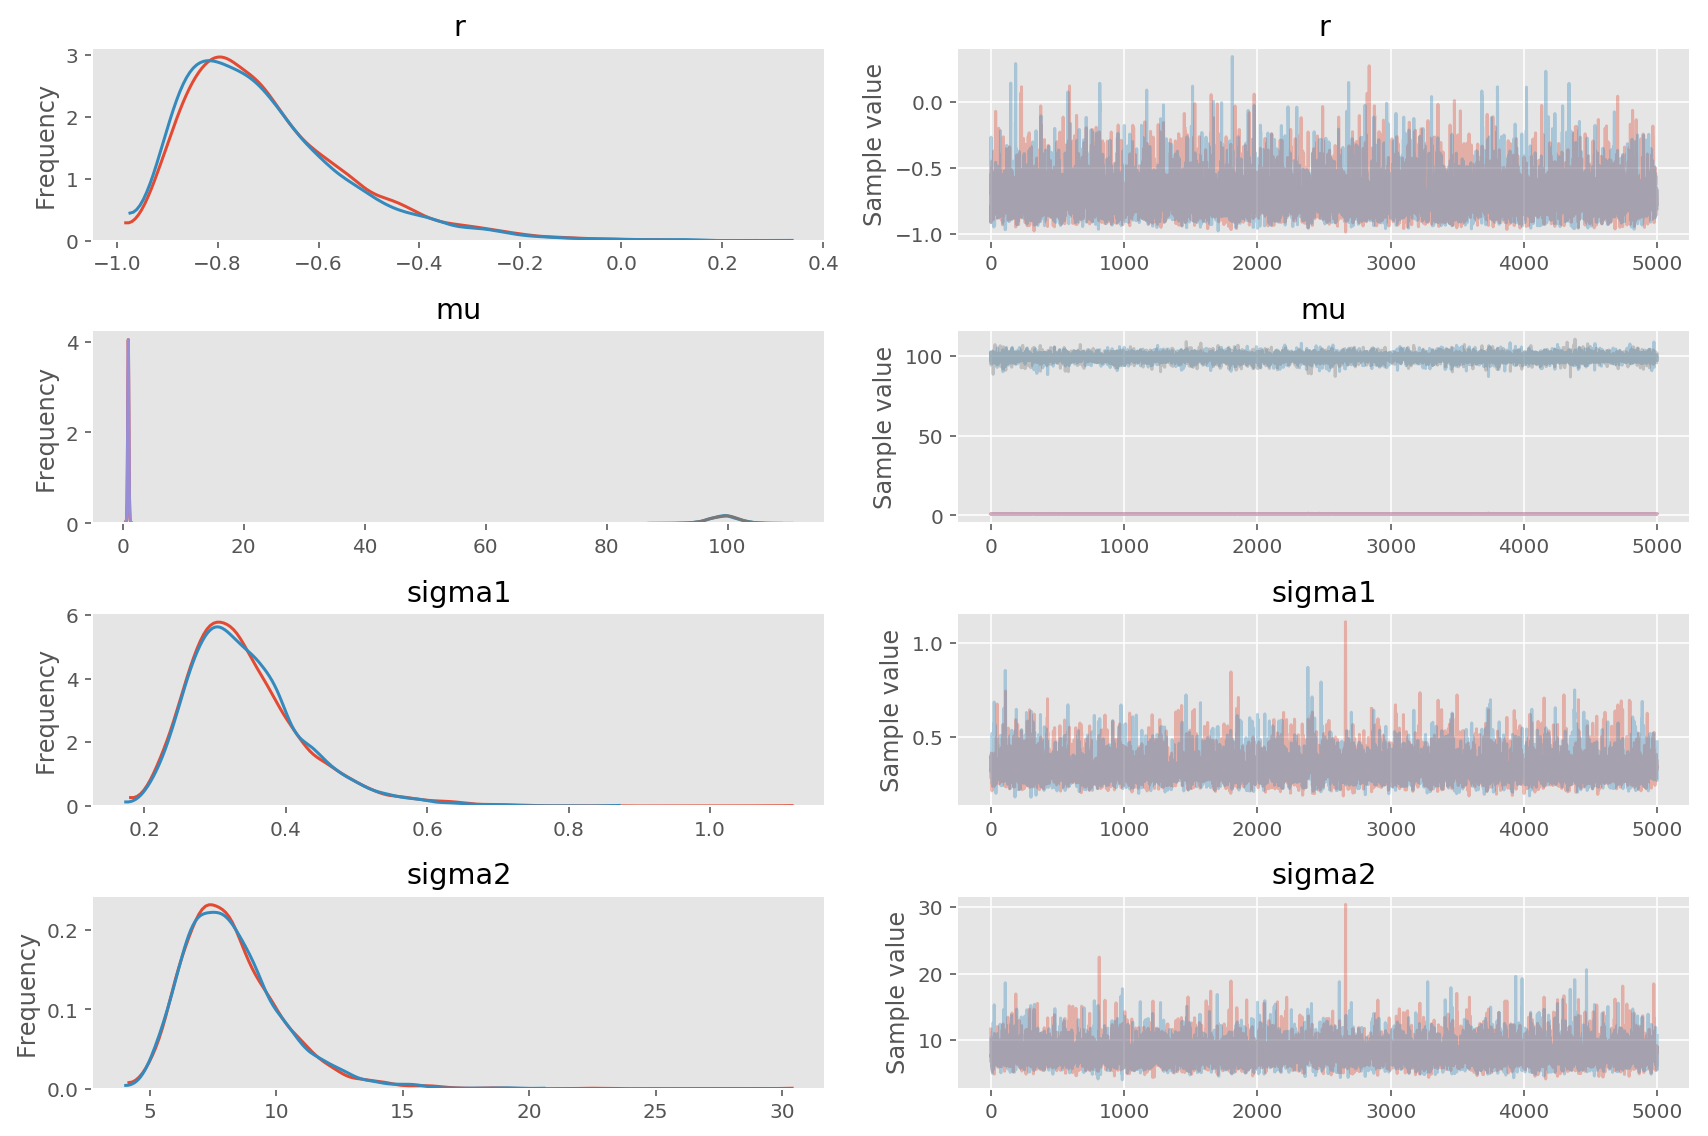

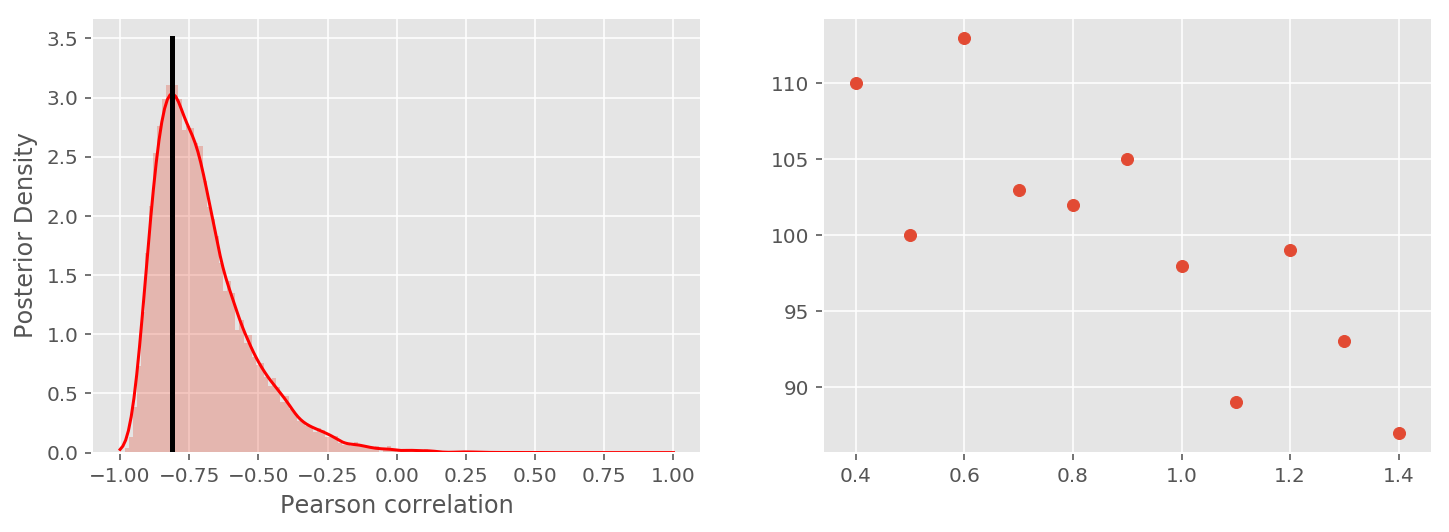

In [5]:
burnin = 5000
pm.traceplot(trace2[burnin:], varnames=['r', 'mu', 'sigma1', 'sigma2']);

r = trace2['r'][burnin:]
freqr=scipy.corrcoef(y[:, 0], y[:, 1])
print('The r estimation is: ', np.mean(r, axis=0))
print('The Pearson correlation r is: ', freqr[0, 1])

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
my_pdf = gaussian_kde(r)
x=np.linspace(-1, 1, 200)
ax0.plot(x, my_pdf(x), 'r') # distribution function
ax0.hist(r, bins=100, normed=1, alpha=.3)
ax0.plot([freqr[0, 1], freqr[0, 1]], [0, 3.5], 'k', lw=2.5)
plt.xlabel('Pearson correlation')
plt.ylabel('Posterior Density')

ax1 = plt.subplot(gs[1])
ax1.scatter(y[:, 0], y[:, 1])
plt.show()

## 5.3 The kappa coefficient of agreement
  
A measurement to decide how well one decision-making method agrees with another.
For this problem, when both decision-making methods make n independent assessments, the data y take the form of four counts: a observations where both methods decide “one,” b observations where the objective method decides “one” but the surrogate method decides “zero,” c observations where the objective method decides “zero” but the surrogate method decides “one,” and d observations where both methods decide “zero,” with n = a + b + c + d.

$$ \kappa = (\xi-\psi)/(1-\psi)  $$
$$ \xi = \alpha\beta + (1-\alpha) \gamma  $$
$$ \psi = (\pi_{a}+\pi_{b})(\pi_{a}+\pi_{c})+(\pi_{b}+\pi_{d})(\pi_{c}+\pi_{d})  $$
$$ \alpha,\beta,\gamma \sim \text{Beta} (1, 1) $$  
$$ \pi_{a} = \alpha\beta  $$ 
$$ \pi_{b} = \alpha(1-\beta)  $$  
$$ \pi_{c} = (1-\alpha)(1-\gamma)  $$  
$$ \pi_{d} = (1-\alpha)\gamma  $$  
$$ y \sim \text{Multinomial} ([\pi_{a},\pi_{b},\pi_{c},\pi_{d}],n)  $$

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 21.268:   4%|▍         | 8913/200000 [00:01<00:27, 6932.54it/s]
Convergence archived at 9600
Interrupted at 9,600 [4%]: Average Loss = 87.935
100%|██████████| 10500/10500.0 [00:17<00:00, 608.45it/s]


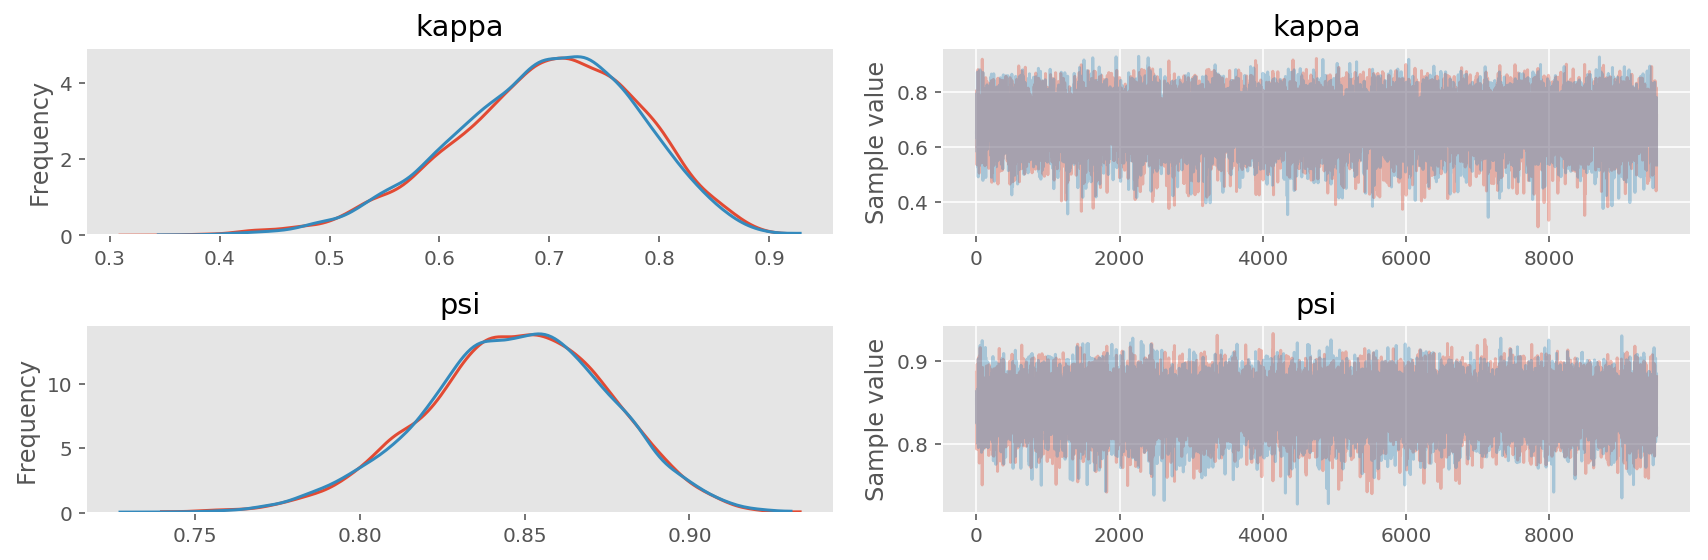

In [6]:
# CHOOSE a data set:
# Influenza 
y = np.array([14, 4, 5, 210])
# Hearing Loss 
# y = np.array([20, 7, 103, 417])
# Rare Disease
# y = np.array([0, 0, 13, 157])

with pm.Model() as model1:
    # prior
    alpha = pm.Beta('alpha', alpha=1, beta=1)
    beta = pm.Beta('beta', alpha=1, beta=1)
    gamma = pm.Beta('gamma', alpha=1, beta=1)
    
    pi1 = alpha*beta
    pi2 = alpha*(1-beta)
    pi3 = (1-alpha)*(1-gamma)
    pi4 = (1-alpha)*gamma
    
    # Derived Measures   
    # Rate Surrogate Method Agrees With the Objective Method
    xi = alpha*beta+(1-alpha)*gamma
    
    yd = pm.Multinomial('yd', n=y.sum(), p=[pi1, pi2, pi3, pi4], observed=y)

    # Rate of Chance Agreement
    psi = pm.Deterministic('psi', (pi1+pi2)*(pi1+pi3)+(pi2+pi4)*(pi3+pi4))
    
    # Chance-Corrected Agreement
    kappa = pm.Deterministic('kappa', (xi-psi)/(1-psi))
    
    trace=pm.sample(1e4, njobs=2)

pm.traceplot(trace[500:], varnames=['kappa', 'psi']);

# Compare to Cohen's point estimate
n = y.sum()
p0 = (y[0]+y[3])/n
pe = (((y[0]+y[1]) * (y[0]+y[2])) + ((y[1]+y[3]) * (y[2]+y[3]))) / n**2
kappa_Cohen = (p0-pe) / (1-pe)

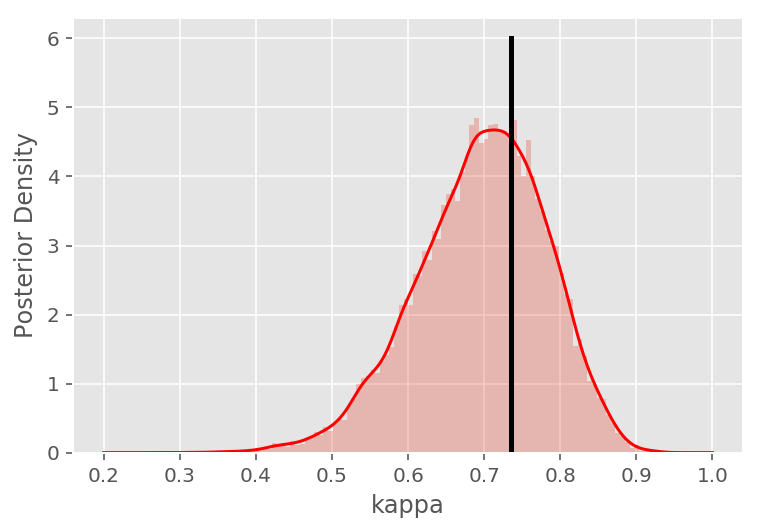

Cohen's point estimate:  0.735794380748
MCMC estimate:  0.696339332327


In [7]:
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 

kappa = trace['kappa'][500:]

my_pdf = gaussian_kde(kappa)
x = np.linspace(0.2, 1, 200)
plt.plot(x, my_pdf(x), 'r') # distribution function

plt.hist(kappa, bins=100, normed=1, alpha=.3)
plt.plot([kappa_Cohen, kappa_Cohen], [0, 6], 'k', lw=2.5)
plt.xlabel('kappa')
plt.ylabel('Posterior Density')
plt.show()

print("Cohen's point estimate: ", kappa_Cohen)
print("MCMC estimate: ", np.mean(kappa))

## 5.4 Change detection in time series data
  
Detecting a single change point in time series.

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \lambda \sim \text{Gamma} (.001, .001)  $$
$$ \tau \sim \text{Uniform} (0, t_{max}) $$  
$$   c_{i} \sim
\begin{cases}
\text{Gaussian}(\mu_{1}, \lambda),  & \text{if $t_{i} \lt \tau$} \\
\text{Gaussian}(\mu_{2}, \lambda),  & \text{if $t_{i} \ge \tau$}
\end{cases}  $$

Assigned NUTS to mu
Assigned NUTS to lambd_log__
Assigned Metropolis to tau
100%|██████████| 10500/10500.0 [01:24<00:00, 124.38it/s]


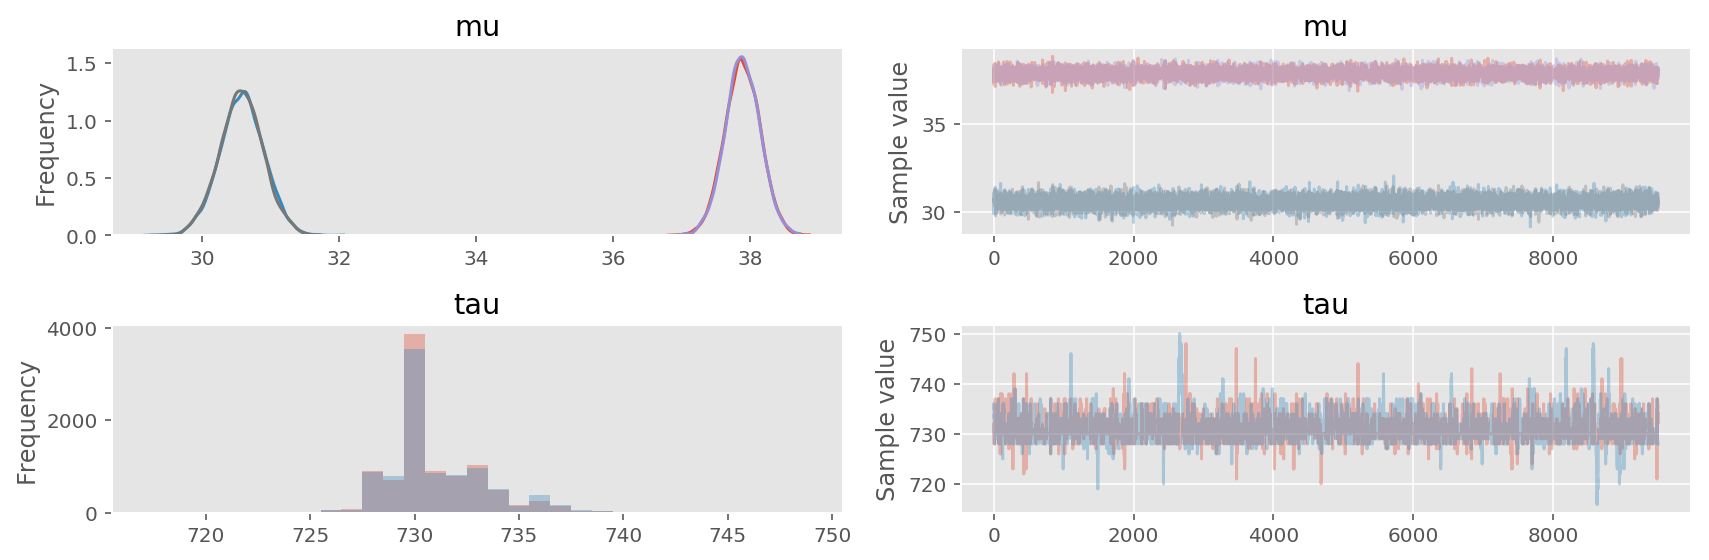

In [8]:
# pymc3
# Load data
dat = pd.read_csv('changepointdata.csv')

c = dat.data
n = np.size(c)
sample = np.arange(0, n)

with pm.Model() as model3:
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=2)
    # λ∼Gamma(.001,.001)
    lambd = pm.Gamma('lambd', alpha=.001, beta=.001)
    #　τ∼Uniform(0,tmax)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)
    
    muvect = pm.math.switch(tau>=sample, mu[0], mu[1])

    cobs = pm.Normal('cobs', mu=muvect, tau=lambd, observed=c)
    
    trace1=pm.sample(1e4, njobs=2)

pm.traceplot(trace1[500:], varnames=['mu', 'tau']);

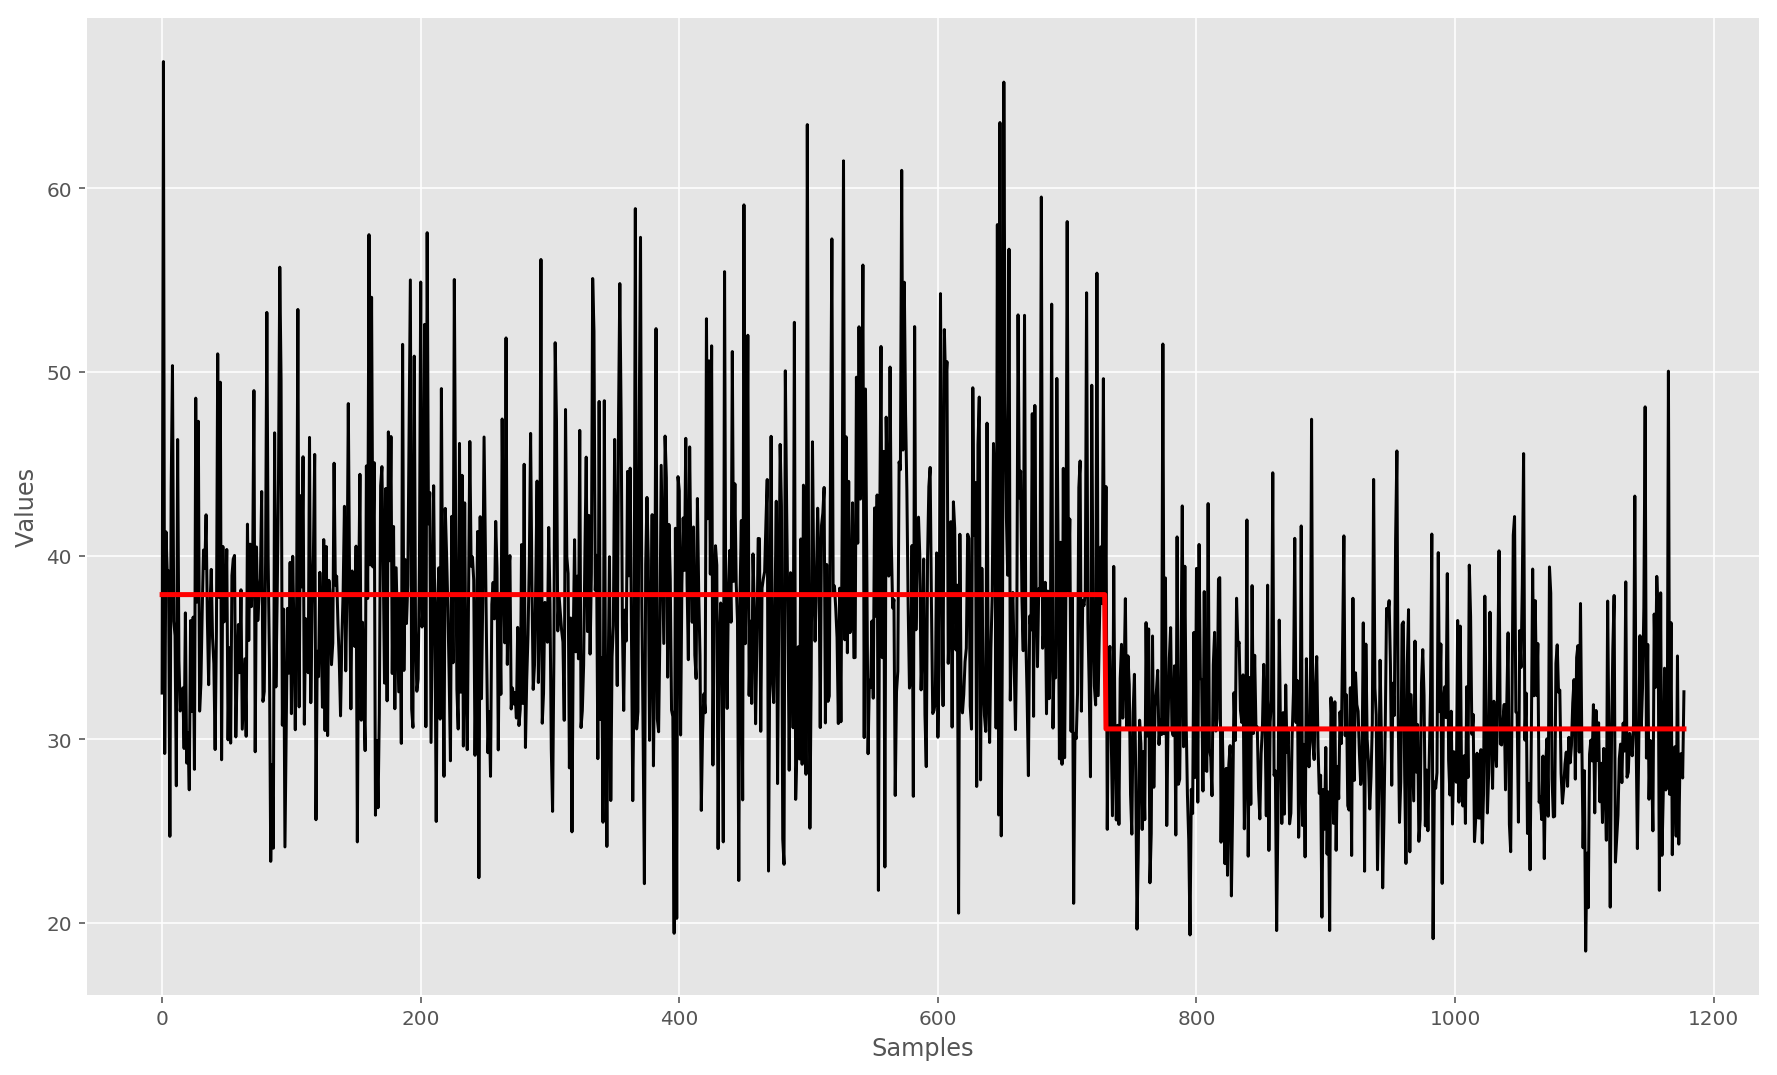

[ 37.88279938  30.57116944]
730


In [9]:
MCtau = trace1['tau'][500:]
MCmu = trace1['mu'][500:]

mu1 = np.mean(MCmu, axis = 0)
tau1 = int(np.mean(MCtau))
fited = np.zeros(n)
fited[:tau1] = np.ones(tau1)*mu1[0]
fited[tau1:] = np.ones(n-tau1)*mu1[1]

plt.figure(1, figsize=(15, 9))
plt.plot(np.arange(0, n, 1), c, color='k')
plt.plot(np.arange(0, n, 1), fited, color='r', lw=2.5)
plt.xlabel("Samples")
plt.ylabel("Values")

plt.show()
print (mu1)
print (tau1)

## 5.5 Censored data

After 949 failed attempts, Cha Sa-Soon from Korea finally passed her theoretical drivers exam. What can we infer about theta, the probability of answering any one question correctly?

$$ \theta \sim \text{Uniform}(0.25, 1) $$
$$ z_{i} \sim \text{Binomial}(\theta, n) $$
$$ 15 \le z_{i} \le 25, \text{if} \; y_{i} = 1 $$ 


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 27,319:   5%|▌         | 10161/200000 [00:00<00:16, 11349.77it/s]
Convergence archived at 10200
Interrupted at 10,200 [5%]: Average Loss = 41,082
100%|██████████| 3500/3500.0 [00:02<00:00, 1196.71it/s]


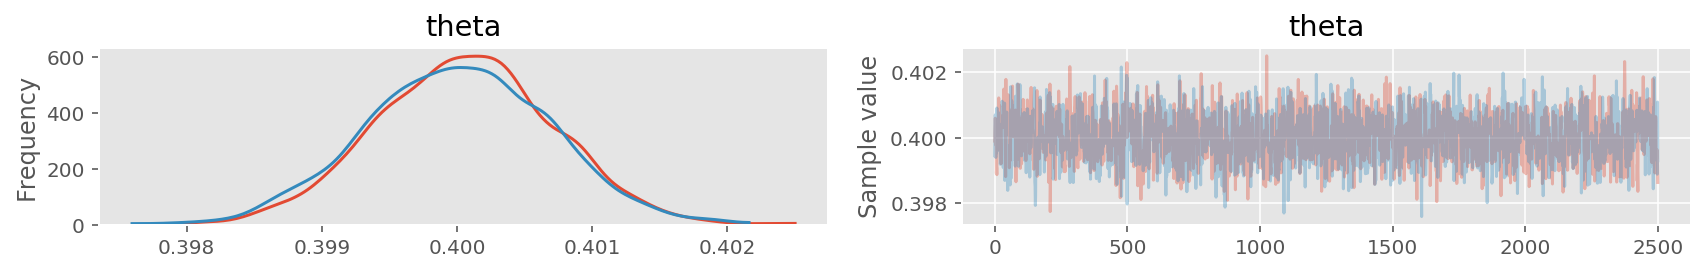

In [10]:
nattempts = 950   
nfails = 949   
n = 50    # Number of questions
y = np.zeros(nattempts)
y[nattempts-1] = 1
z = 30
unobsmin = 15
unobsmax = 25
unobsrange = np.arange(unobsmin, unobsmax+1)
from pymc3.distributions import dist_math

def logp(value, n, p):
    return dist_math.bound(dist_math.binomln(n, value) + 
                          dist_math.logpow(p, value) + 
                          dist_math.logpow(1-p, n-value),
                          0 <= value, value <= n,
                          0 <= p, p <= 1)
def Censorlike(value=z, n=n, censorn=nfails, unobs=unobsrange):
    ylikeobs = logp(value=value, n=n, p=theta)
    ylikeunobs = 0
    for i in unobs:
        ylikeunobs += logp(value=i, n=n, p=theta)
    return ylikeobs+ylikeunobs*censorn
    
with pm.Model():
    theta = pm.Uniform("theta", lower=.25, upper=1)
    
    ylike = pm.DensityDist('ylike', Censorlike, 
                           observed={'value': z, 'n': n, 'censorn': nfails, 'unobs': unobsrange})
    trace = pm.sample(3e3, njobs=2)

pm.traceplot(trace[500:])
plt.show()

## 5.6 Recapturing planes

$$ k \sim \text{Hypergeometric}(n, x, t) $$ 
$$ t  \sim \text{Categorical}(\alpha) $$ 

 [-----------------100%-----------------] 20000 of 20000 complete in 1.1 secPlotting tau


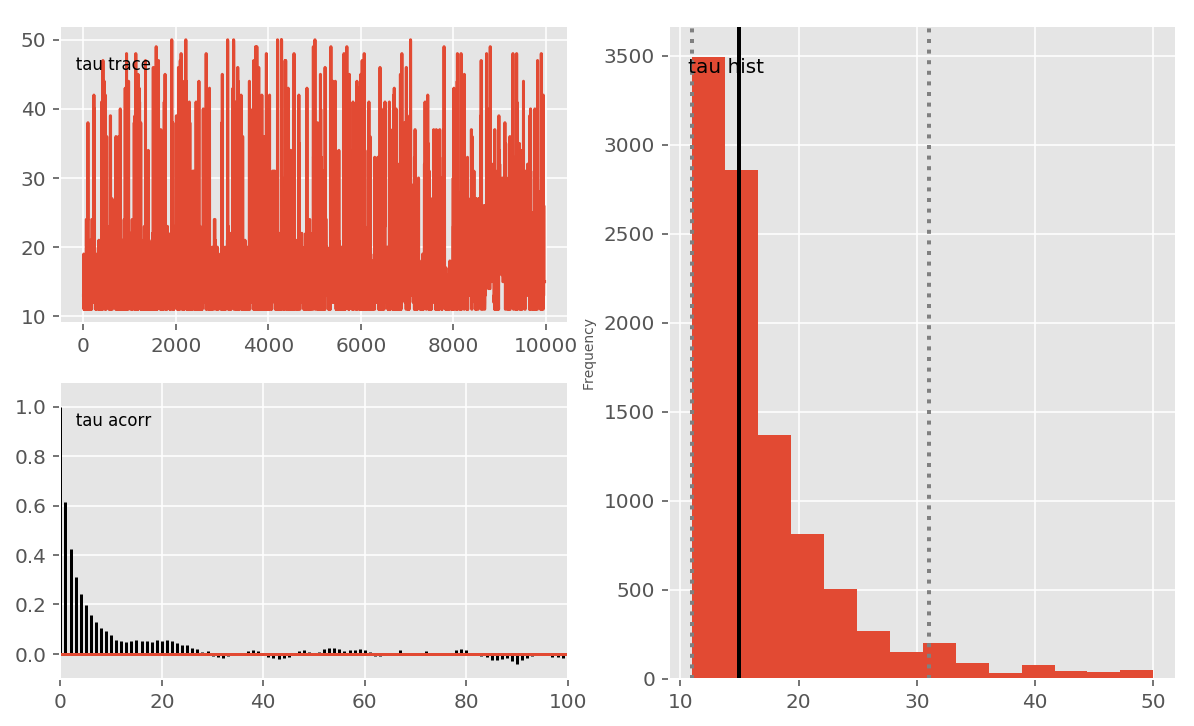

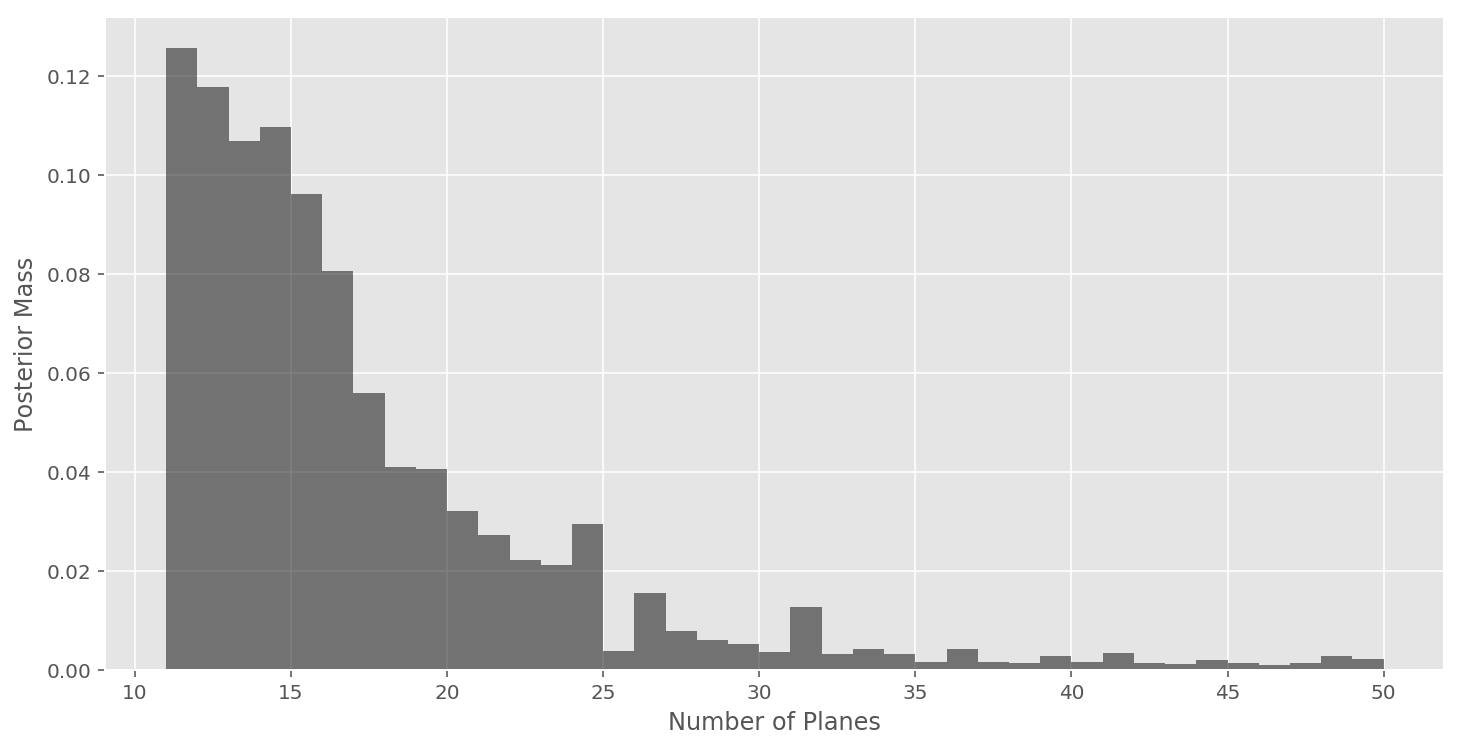

In [11]:
import matplotlib.pyplot as plt
import pymc as pymc
import numpy as np
%matplotlib inline

x = 10 # number of captures
k = 4  # number of recaptures from n
n = 5  # size of second sample
tmax = 50 # maximum population size

tau = pymc.DiscreteUniform("tau", lower = x + (n-k), upper = tmax)
kobs = pymc.Hypergeometric("kobs", N = tau, n = n, m = x, value = k, observed=True)

testmodel = pymc.Model([kobs,tau])
mcmc = pymc.MCMC(testmodel)
mcmc.sample(iter = 20000, burn = 50, thin = 2)

pymc.Matplot.plot(mcmc)

tau =  mcmc.trace("tau")[:]

plt.figure(figsize=(12, 6)) 
plt.hist(tau, bins=tmax - (x + (n-k)), normed=1,alpha=.5,color='k')
plt.xlabel('Number of Planes')
plt.ylabel('Posterior Mass')
plt.show()

Assigned Metropolis to tau
100%|██████████| 10500/10500.0 [00:01<00:00, 8550.65it/s]


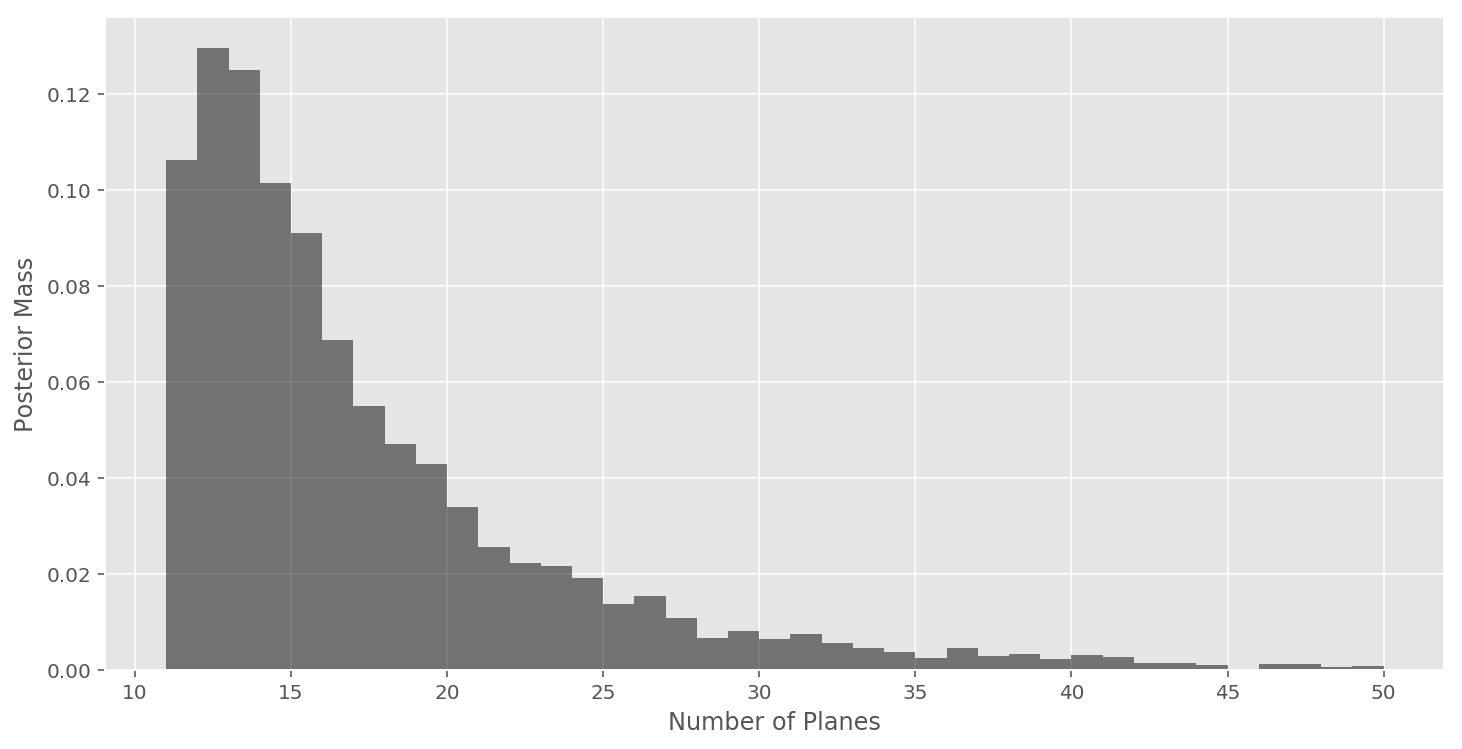

In [12]:
# pymc3 - Hypergeometric Likelihood Via Zeros Trick as in JAGS

x = 10 # number of captures
k = 4  # number of recaptures from n
n = 5  # size of second sample
tmax = 50 # maximum population size

with pm.Model():
    tau = pm.DiscreteUniform("tau", lower=x + (n-k), upper=tmax)
    logterm1 = dist_math.factln(x+.01)-dist_math.factln(k+.01)-dist_math.factln(x-k+.01)
    logterm2 = dist_math.factln(tau-x+.01)-dist_math.factln(n-k+.01)-dist_math.factln((tau-x)-(n-k)+.01)
    logterm3 = dist_math.factln(tau+.01)-dist_math.factln(n+.01)-dist_math.factln(tau-n+.01)
    C = 1000
    phi = -(logterm1+logterm2-logterm3)+C 
    
    obs = pm.Poisson("obs",mu=phi,observed=0)
    trace = pm.sample(1e4)
    
tau = trace['tau'][500:]

plt.figure(figsize=(12, 6)) 
plt.hist(tau, bins=tmax - (x + (n-k)), normed=1,alpha=.5,color='k')
plt.xlabel('Number of Planes')
plt.ylabel('Posterior Mass')
plt.show()